In [10]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import to_datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array

In [11]:
# date-time parsing function for loading the dataset
def parser(x):
	return to_datetime.strptime('190'+x, '%Y-%m')

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2])))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

In [44]:
df = read_csv('GBPUSD1440.csv',delimiter=',')
df.columns =['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']

In [45]:
from pandas import DataFrame

In [12]:
# load dataset
series = DataFrame(df['Close'])
# configure
n_lag = 30
n_seq = 10
n_test = 100
n_epochs = 50
n_batch = 10
n_neurons = 100
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

In [13]:
test.shape

(100, 40)

In [14]:
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)


In [15]:
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)


1/1 [==============================] - 0s 30ms/step
t+1 RMSE: 0.005867
t+2 RMSE: 0.008655
t+3 RMSE: 0.010189
t+4 RMSE: 0.010957
t+5 RMSE: 0.011851
t+6 RMSE: 0.012841
t+7 RMSE: 0.014135
t+8 RMSE: 0.016013
t+9 RMSE: 0.017939
t+10 RMSE: 0.019839


In [35]:
# plot the forecasts in the context of the original dataset
def plot_only_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
# 	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis)
# 		break
	# show the plot
	pyplot.show()

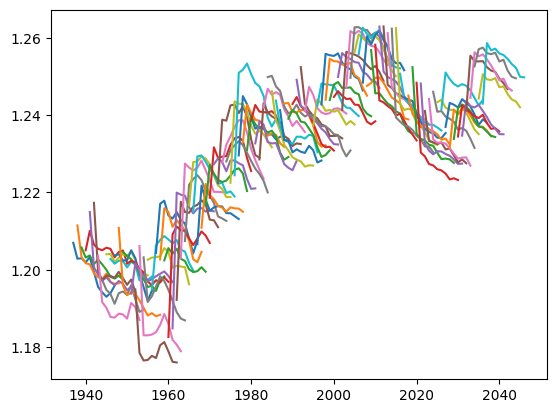

In [36]:
# plot forecasts
plot_only_forecasts(series, forecasts, n_test+10)

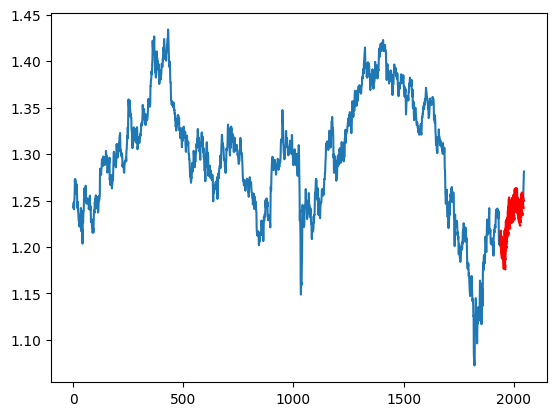

In [17]:
# plot forecasts
plot_forecasts(series, forecasts, n_test+10)